# ****Covid-19 from Chest X-Ray Images****

The COVID-19 pandemic has posed a significant challenge to the healthcare industry worldwide. Early detection and classification of COVID-19 patients are critical for reducing the spread of the virus. This task can be facilitated by analyzing chest X-rays (CXRs) of patients. In this Jupyter notebook, we will develop deep learning models using convolutional neural networks (CNNs) and feedforward neural networks (FNNs) to classify COVID-19 and normal CXRs. We will also compare the performance of both models to determine the suitability of CNNs for image classification.

To improve the generalization ability of our models, we will explore several techniques, such as data augmentation, weight decay, early stopping, ensembles, dropout, batch normalization, learning rate schedule. We will demonstrate how each of these techniques was used and justify which of them (or maybe more than one) would be the best generalization technique for this task.

The dataset consists of 100 COVID-19 and 100 normal CXR images, which will be split into 80% training and 20% testing. We will report the performance of our models in terms of accuracy, explaining the network architecture used in each model and how we monitored the convergence of the model. We will also explain how overfitting was prevented in our models.

We will also employ a transfer learning process, use a pre-trained ResNet-50 model (with ImageNet weights) to develop a binary classification model that can classify Covid-19 and Normal CXRs.

Overall, this Jupyter notebook aims to provide a comprehensive understanding of the application of deep learning models for COVID-19 and normal CXR classification and the techniques used to improve model performance and generalization ability.

# 1.Extending this notebook

<div style="background-color:#F3FCF5; vertical-align: middle; padding:40px 0;">
#### Define model variables
CNN_CLASSES=2

#### Initialization of the resusable layers and dataset classes
data_set = DataSet()
cnn_layers = KerasLayers()

#### add data augumentation
data_set.add_rotation(5)
data_set.add_zoom(0.1)
data_set.add_shear(0.1)
data_set.add_width_shift(0.1)
data_set.add_height_shift(0.1)
data_set.add_horizontal_flip()

#### load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()

#### add keras layers for CNN architecture
cnn_layers.add_input_shape_conv2D_layer(size=32, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), activation_fn='relu', use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)
cnn_layers.flatten()
........
cnn_layers.add_dense_layer(2, 'softmax')


#### output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(cnn_layers.layers)
    ])

#### train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )      
    
</div>


### **2.Imports**

In [1]:
# libraries imports
import numpy as np
import pandas as pd
import os

# matplot
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.pyplot import figure

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.resnet50 import ResNet50


### 3.Global variables

In [2]:
# Global variables to be used to control the model behaviour
# Dataset Directory
DATA_SET_DIRECTORY= os.getcwd() + '/covid-19-dataset'
TEST_SET_DIRECTORY= os.path.dirname(os.path.abspath("__file__")) + f'/test_set'

# Class directories, mind that more classes can be added for problems with 
# more classes in the dataset and the concepts still applies
CLASS_1_SUBDIRECTORY='Covid-19'
CLASS_2_SUBDIRECTORY='Normal'

# Change to control how confident a medical practioner is willing to
# trust the model, values above the set threshold will make the model
# return covid-19 positive, values lower will return covid-19 negative
# values that are in between will return covid-19 borderline
COVID19_CERTAIN_POSITIVE_THRESHOLD=0.7
COVID19_CERTAIN_NEGATIVE_THRESHOLD=0.4

# training images parameters
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

# image plot parameters
WIDTH_IN_INCHES=10
HEIGHT_IN_INCHES=10
NUMBER_OF_COLUMNS=6

# model parameters
TRAINING_VALIDATION_SPLIT=0.2
EPOCHS=100

### 4.Defining Callbacks
Here we define the callback by adding early stopping
if the validation accuracy is not improving the 
training will stop

In [3]:
# Define callbacks
CALLBACKS = [
             EarlyStopping(monitor='val_accuracy', verbose=1, patience=8)
]

## 5.Helper functions and classes
The functions and classes that are used throughout the notebook, these functions and classes has been seperated to promote the reusability of the code and the notebook, and to ensure that other Machine learning researchers can reuse the notebook with minimal code changes, extensive documentation was also taken into consideration to allow
future researchers/users of the noteboook to understand how the functions and classes work, and how they could be used to train a new model with minimal code changes

In [4]:
def plot(images, labels):
    """
    Display a grid of images and their corresponding labels.

    Args:
        images (list): A list of file paths to the images to be displayed.
        labels (list): A list of labels corresponding to each image in `images`.

    Returns:
        None

    Displays a grid of subplots, with each subplot showing an image from `images`
    and its corresponding label from `labels`. The images are displayed in grayscale
    using matplotlib, and the subplots are arranged in a single row with equal size.
    """
    for i in range(len(labels)):
        ax = plt.subplot(1, len(labels), i + 1)
        plt.subplot(1, NUMBER_OF_COLUMNS, i+1)
        img = mpimg.imread(images[i])
        plt.imshow(img, cmap='gray')
        plt.title(labels[i])
        plt.axis("off")
        plt.gcf().set_size_inches(HEIGHT_IN_INCHES, WIDTH_IN_INCHES)
    plt.show()
    

def train(
    model, 
    loss, 
    learning_rate, 
    epochs, 
    train_generator, 
    validation_generator,
    callbacks=None):
    """
    Train a neural network model using a specified loss function, optimizer, and learning rate.

    Args:
        model (tf.keras.Model): The neural network model to train.
        loss (str or tf.keras.losses.Loss): The loss function to use during training.
        learning_rate (float): The learning rate to use during training.
        epochs (int): The number of epochs to train the model for.
        training_dataset (tf.data.Dataset): The dataset containing the training data.
        validation_dataset (tf.data.Dataset): The dataset containing the validation data.
        callbacks (list or None): Optional list of Keras callbacks to use during training.

    Returns:
        A `History` object that contains information about the training process, including
        the training and validation loss and accuracy for each epoch.

    Compiles the neural network model using the specified loss function and optimizer
    (Adam with the specified learning rate), and trains the model for the specified number
    of epochs using the training and validation datasets. The `fit` method is used to
    train the model, with the `callbacks` argument used to specify any additional Keras
    callbacks to use during training (such as early stopping or checkpointing).
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss=loss, 
        metrics=['accuracy']
    )

    
    return model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        callbacks=callbacks)

    
def show_model_metrics(model, test_ds):
    """
    Evaluate a trained TensorFlow model on a validation dataset and display its metrics.

    Args:
        model (tf.keras.Model): The trained TensorFlow model to evaluate.

    Returns:
        None

    Uses the `evaluate` method to evaluate the trained model on a validation dataset, and
    displays the resulting test accuracy. Also displays a summary of the model architecture,
    including the number of parameters in each layer.
    """
    test_loss, test_acc = model.evaluate(
        test_ds, 
        steps=len(test_ds)
    )
    print("Test accuracy:", test_acc)
    print("Test loss:", test_loss)
    model.summary()
    
def show_accuracy_and_loss(history):
    """
    Plot the training and validation accuracy and loss from a TensorFlow model's history.

    Args:
        history (tf.keras.callbacks.History): The history object returned by `model.fit()`.

    Returns:
        None

    Extracts the accuracy and loss data from the provided `history` object and plots it
    using `matplotlib`. Two plots are created: one for the training and validation loss,
    and one for the training and validation accuracy. These plots can be used to visualize
    the performance of the model during training and to identify potential overfitting.
    """
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

def visualize_images(images, labels):
    """
    Display a set of images and their corresponding labels in a plot.

    Args:
        images (list): A list of image file paths or NumPy arrays.
        labels (list): A list of string labels corresponding to each image.

    Returns:
        None

    Calls the `plot` function to display a set of images and their corresponding labels
    in a plot. The `images` argument should be a list of file paths or NumPy arrays
    containing the image data, and the `labels` argument should be a list of string
    labels corresponding to each image. The resulting plot is displayed inline in the
    notebook.
    """
    plot(images, labels)

In [5]:
class DataSet:
    """A class for creating and managing data generators for image datasets.

    Attributes:
        layers (int): The number of image layers to use.
        rescale (float): The scaling factor for the pixel values.
        rotation_range (int): The range of rotation values to use for data augmentation.
        width_shift_range (int): The range of width shift values to use for data augmentation.
        shear_range (int): The range of shear values to use for data augmentation.
        zoom_range (int): The range of zoom values to use for data augmentation.
        horizontal_flip (bool): Whether or not to use horizontal flipping for data augmentation.
        height_shift (int): The range of height shift values to use for data augmentation.
        width_shift (int): The range of width shift values to use for data augmentation.
        validation_split (float): The fraction of the data to use for validation.

        image_generator (ImageDataGenerator): The image data generator object.
        training_generator (DirectoryIterator): The training data generator object.
        validation_generator (DirectoryIterator): The validation data generator object.
    """
    def __init__(self):
        self.rescale = 1.0 / 255
        self.rotation_range = 0
        self.width_shift_range = 0
        self.shear_range = 0
        self.zoom_range = 0
        self.horizontal_flip = False
        self.height_shift = 0
        self.width_shift = 0
        self.validation_split = 0.3
        self.image_generator = None
        self.test_image_generator = ImageDataGenerator(rescale=1./255)  # create a test generator with no augmenatation

        self.training_generator = None
        self.validation_generator = None
        self.test_generator = None

    def create_image_generator(self):
        """Creates the image data generator object."""
        self.image_generator = ImageDataGenerator(
            rescale=self.rescale,
            rotation_range=self.rotation_range,
            width_shift_range=self.width_shift,
            height_shift_range=self.height_shift,
            shear_range=self.shear_range,
            zoom_range=self.zoom_range,
            horizontal_flip=self.horizontal_flip,
            validation_split=self.validation_split
        )

    def create_train_generator(self):
        """Creates the training data generator object."""
        self.training_generator = self.image_generator.flow_from_directory(
            DATA_SET_DIRECTORY,
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=32,
            class_mode="categorical",
            subset="training",
        )
        return self.training_generator

    def create_validation_generator(self):
        """Creates the validation data generator object."""
        self.validation_generator = self.image_generator.flow_from_directory(
            DATA_SET_DIRECTORY,
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=32,
            class_mode="categorical",
            subset="validation",
        )
        
        return self.validation_generator

    def create_test_generator(self):
        """Creates the test data generator object."""
        self.test_generator = self.test_image_generator.flow_from_directory(
            TEST_SET_DIRECTORY,
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=32,
            class_mode="categorical",
        )
        
        return self.test_generator
    
    def add_rotation(self, rotation):
        """Sets the rotation range for data augmentation."""
        self.rotation_range = rotation

    def add_width_shift(self, shift):
        """Sets the width shift range for data augmentation."""
        self.width_shift = shift

    def add_height_shift(self, shift):
        """Sets the height shift range for data augmentation."""
        self.height_shift = shift
        
    def add_shear(self, shear):
        """Sets the shear range for data augmentation."""
        self.shear_range = shear

    def add_zoom(self, zoom):
        """Sets the zoom range for data augmentation."""
        self.zoom_range = zoom

    def add_horizontal_flip(self):
        """Enables horizontal flipping for data augmentation."""
        self.horizontal_flip = True

    def plot(self):
        """Plot augumented images to aid the note book users in identifying 
        the effects of data augumentations"""
        aug_images, _ = self.training_generator.next()
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
        for i, ax in enumerate(axes.flat):
            ax.imshow(aug_images[i])
            ax.axis('off')
        plt.show()



In [6]:

class KerasLayers():
    """
    A class for creating a list of Keras neural network layers

    Attributes:
        layers (list): A list of Keras layers for data augmentation.

    Example usage:
        cnn_layers = KerasLayers()
        cnn_layers.flatten(input_shape=(224,224,3))
        cnn_layers.add_dense_layer(256, 'relu')
    """
    def __init__(self):
            """
            Initializes the LayerBuilder object with an empty list of layers.

            Parameters:
            layers (list): A list of layers to start with (default is an empty list).
            """
            self.layers = []
        
    def add_input_shape_conv2D_layer(self, size, input_shape, activation_fn, use_bias=False):
        """
        Adds a Conv2D layer with input shape to the layer list.

        Parameters:
        size (int): The number of filters in the Conv2D layer.
        activation_fn (str or object): The activation function to use.
        input_shape (tuple): The shape of the input to the layer.
        use_bias (bool): Whether or not to use a bias term in the Conv2D layer.

        Returns:
        None
        """
        self.layers.append(tf.keras.layers.Conv2D(size, (3,3), input_shape=input_shape, activation=activation_fn, use_bias=use_bias))
    
    def add_conv2D_layer(self, size, activation_fn, use_bias=False):
        """
        Adds a Conv2D layer to the layer list.

        Parameters:
        size (int): The number of filters in the Conv2D layer.
        activation_fn (str or object): The activation function to use.
        use_bias (bool): Whether or not to use a bias term in the Conv2D layer.

        Returns:
        None
        """
        self.layers.append(tf.keras.layers.Conv2D(size, (3,3), activation=activation_fn, use_bias=use_bias))
       
    def add_l1_regularized_conv2D_layer(self, size, activation_fn, use_bias, l_value):
        """
        Adds a Conv2D layer with L1 regularization to the layer list.

        Parameters:
        size (int): The number of filters in the Conv2D layer.
        activation_fn (str or object): The activation function to use.
        use_bias (bool): Whether or not to use a bias term in the Conv2D layer.
        l_value (float): The strength of the L1 regularization.

        Returns:
        None
        """
        self.layers.append(tf.keras.layers.Conv2D(size, (3,3), activation=activation_fn, use_bias=use_bias, kernel_regularizer=tf.keras.regularizers.l1(l=l_value)))
        
    def add_l2_regularized_conv2D_layer(self, size, activation_fn, use_bias, l_value):
        """
        Adds a Conv2D layer with L2 regularization to the layer list.

        Parameters:
        size (int): The number of filters in the Conv2D layer.
        activation_fn (str or object): The activation function to use.
        use_bias (bool): Whether or not to use a bias term in the Conv2D layer.
        l_value (float): The strength of the L2 regularization.

        Returns:
        None
        """
        self.layers.append(tf.keras.layers.Conv2D(size, (3,3), activation=activation_fn, use_bias=use_bias, kernel_regularizer=tf.keras.regularizers.l2(l=l_value)))
        
    def add_dropout(self, probability):
        """
        Adds a Dropout layer to the layer list.

        Parameters:
        probability (float): The probability of dropping out a neuron.

        Returns:
        None
        """
        self.layers.append(tf.keras.layers.Dropout(probability))
    
    
    def add_max_pooling_2D(self, x, y):
        """
        Adds a 2D max pooling layer to the model.

        Args:
            x (int): The size of the pooling window in the x dimension.
            y (int): The size of the pooling window in the y dimension.

        Returns:
            None
        """
        self.layers.append(tf.keras.layers.MaxPooling2D(x, y))

    def add_average_pooling_2D(self, x, y):
        """
        Adds a 2D average pooling layer to the model.

        Args:
            x (int): The size of the pooling window in the x dimension.
            y (int): The size of the pooling window in the y dimension.

        Returns:
            None
        """
        self.layers.append(tf.keras.layers.AveragePooling2D(
            pool_size=(x, y),
            strides=None,
            padding="valid",
            data_format=None))

    def add_l2_regularized_dense_layer(self, size, activation_fn):
        """
        Adds a dense layer with L2 regularization to the model.

        Args:
            size (int): The number of neurons in the layer.
            activation_fn (str or callable): The activation function for the layer.

        Returns:
            None
        """
        self.layers.append(tf.keras.layers.Dense(size, activation=activation_fn,
                                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))

    def add_dense_layer(self, size, activation_fn):
        """
        Adds a dense layer to the model.

        Args:
            size (int): The number of neurons in the layer.
            activation_fn (str or callable): The activation function for the layer.

        Returns:
            None
        """
        self.layers.append(tf.keras.layers.Dense(size, activation_fn))

    def add_batch_normalization(self):
        """
        Adds a dense layer to the model.

        Args:
            size (int): The number of neurons in the layer.
            activation_fn (str or callable): The activation function for the layer.

        Returns:
            None
        """
        self.layers.append(tf.keras.layers.BatchNormalization())

    def flatten(self, input_shape=None):
        """
        Adds a flatten layer to the model.

        Args:
            input_shape (tuple or None): The shape of the input to the layer. Defaults to None.

        Returns:
            None
        """
        if input_shape is None:
            self.layers.append(tf.keras.layers.Flatten())
        else:
            self.layers.append(tf.keras.layers.Flatten(input_shape=input_shape))



## 6.Data visualization
We plot 6 images from the Covid-19 dataset and 6 images from the Normal dataset, this helps to get a sense of the
data and aids with visualization

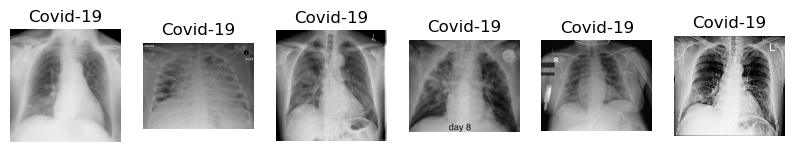

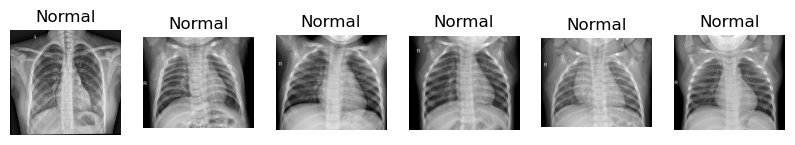

In [7]:
IMAGES_PER_ROW=6

visualize_images(
    [f'{DATA_SET_DIRECTORY}/{CLASS_1_SUBDIRECTORY}/{name}' for name in os.listdir(f'{DATA_SET_DIRECTORY}/{CLASS_1_SUBDIRECTORY}')[:IMAGES_PER_ROW]],
    ["Covid-19" for covid in range(IMAGES_PER_ROW)])
visualize_images(
    [f'{DATA_SET_DIRECTORY}/{CLASS_2_SUBDIRECTORY}/{name}' for name in os.listdir(f'{DATA_SET_DIRECTORY}/{CLASS_2_SUBDIRECTORY}')[:IMAGES_PER_ROW]],
    ["Normal" for covid in range(IMAGES_PER_ROW)])


# 7.Subtask 1: Develop deep learning models to classify Covid-19 and Normal CXRs

## 7.1.Subtask 1.1: Develop a FNN model


In [8]:
# Experiment: Use Feed Forward Neural Network (FNN)

# variables
FNN_CLASSES=2

# initialization
data_set = DataSet()
fnn_layers = KerasLayers()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()

# add keras layers for FNN architecture
fnn_layers.add_dense_layer(64, 'relu')
fnn_layers.add_dense_layer(32, 'relu')
fnn_layers.flatten(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
fnn_layers.add_dense_layer(FNN_CLASSES, 'softmax')

# output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(fnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )    


Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100


2023-05-11 19:31:53.353299: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 3s 1s/step - loss: 9.1075 - accuracy: 0.5625 - val_loss: 39.2504 - val_accuracy: 0.4375
Epoch 2/100
3/3 [==============================] - 3s 995ms/step - loss: 12.9514 - accuracy: 0.6562 - val_loss: 3.6907 - val_accuracy: 0.8125
Epoch 3/100
3/3 [==============================] - 2s 1s/step - loss: 9.6462 - accuracy: 0.6125 - val_loss: 1.2233 - val_accuracy: 0.8750
Epoch 4/100
3/3 [==============================] - 3s 990ms/step - loss: 2.5176 - accuracy: 0.8750 - val_loss: 2.1556 - val_accuracy: 0.9375
Epoch 5/100
3/3 [==============================] - 2s 842ms/step - loss: 1.9970 - accuracy: 0.9000 - val_loss: 1.1452 - val_accuracy: 0.8438
Epoch 6/100
3/3 [==============================] - 3s 894ms/step - loss: 3.9761 - accuracy: 0.8125 - val_loss: 6.4617 - val_accuracy: 0.7812
Epoch 7/100
3/3 [==============================] - 2s 816ms/step - loss: 1.4616 - accuracy: 0.8875 - val_loss: 3.0283 - val_accuracy: 0.9062
Epoch 8/100
3/3 [============

3/3 [==============================] - 2s 1s/step - loss: 1.6620e-04 - accuracy: 1.0000 - val_loss: 0.3223 - val_accuracy: 0.9375
Epoch 59/100
3/3 [==============================] - 2s 651ms/step - loss: 2.6064e-04 - accuracy: 1.0000 - val_loss: 0.1697 - val_accuracy: 0.9375
Epoch 60/100
3/3 [==============================] - 2s 760ms/step - loss: 2.2159e-04 - accuracy: 1.0000 - val_loss: 0.3529 - val_accuracy: 0.9375
Epoch 61/100
3/3 [==============================] - 2s 630ms/step - loss: 1.6223e-04 - accuracy: 1.0000 - val_loss: 0.2042 - val_accuracy: 0.9688
Epoch 62/100
3/3 [==============================] - 2s 778ms/step - loss: 1.4721e-04 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 63/100
3/3 [==============================] - 2s 851ms/step - loss: 1.3004e-04 - accuracy: 1.0000 - val_loss: 0.3667 - val_accuracy: 0.9375
Epoch 64/100
3/3 [==============================] - 2s 923ms/step - loss: 1.0281e-04 - accuracy: 1.0000 - val_loss: 0.1615 - val_accuracy: 0

In [9]:
# show the model metrics of the FNN model
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)


2/2 [==============================] - 0s 41ms/step - loss: 0.0177 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 0.01765836961567402
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 3213602   
                                                                 
Total params: 3,213,602
Trainable params: 3,213,602
Non-trainable params: 0
_________________________________________________________________


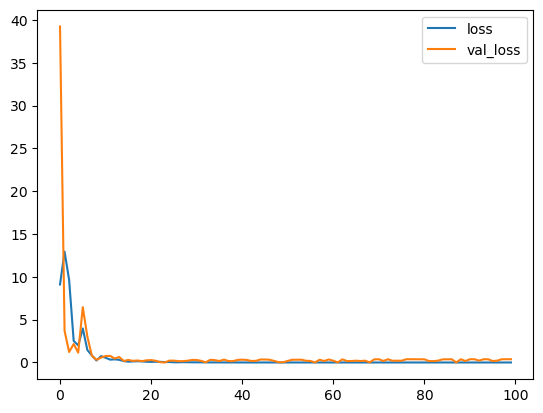

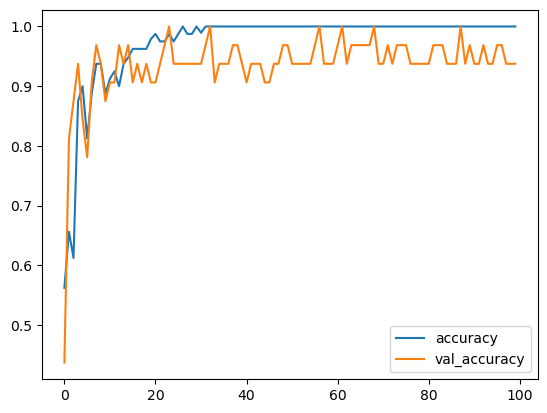

In [10]:
show_accuracy_and_loss(history)

### 7.2.FNN training and model results
When using FNN to classify the Covid-19 images, the model stopped improving after epoch number 30

The model Test accuracy is 100% on data that the model hasn't seen before

We will attempt to train a CNN model on the data and observe the differences

### Test FNN with Augumentation

In [11]:
# Experiment: Use Feed Forward Neural Network (FNN)

# variables
FNN_CLASSES=2

# initialization
data_set = DataSet()
fnn_layers = KerasLayers()

# add data augumentation
data_set.add_rotation(5)
data_set.add_zoom(0.1)
data_set.add_shear(0.1)
data_set.add_width_shift(0.1)
data_set.add_height_shift(0.1)
data_set.add_horizontal_flip()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()


# add keras layers for FNN architecture
fnn_layers.add_dense_layer(64, 'relu')
fnn_layers.add_dense_layer(32, 'relu')
fnn_layers.flatten(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
fnn_layers.add_dense_layer(FNN_CLASSES, 'softmax')

# output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(fnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )    


Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 12.2849 - accuracy: 0.7000 - val_loss: 27.6764 - val_accuracy: 0.4688
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 13.2383 - accuracy: 0.6000 - val_loss: 13.4563 - val_accuracy: 0.4688
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 9.9035 - accuracy: 0.6250 - val_loss: 0.9522 - val_accuracy: 0.9062
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 1.8348 - accuracy: 0.8229 - val_loss: 4.1335 - val_accuracy: 0.7812
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 3.6373 - accuracy: 0.8229 - val_loss: 1.8213 - val_accuracy: 0.9062
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 1.2603 - accuracy: 0.8750 - val_loss: 1.6446 - val_accuracy: 0.9062
Epoch 7/100
3/3 [==============================

Epoch 59/100
3/3 [==============================] - 3s 1s/step - loss: 0.1391 - accuracy: 0.9583 - val_loss: 0.2281 - val_accuracy: 0.9062
Epoch 60/100
3/3 [==============================] - 3s 1s/step - loss: 0.0898 - accuracy: 0.9750 - val_loss: 0.5207 - val_accuracy: 0.8438
Epoch 61/100
3/3 [==============================] - 3s 929ms/step - loss: 0.1083 - accuracy: 0.9750 - val_loss: 0.2605 - val_accuracy: 0.9062
Epoch 62/100
3/3 [==============================] - 3s 1s/step - loss: 0.1146 - accuracy: 0.9750 - val_loss: 0.1025 - val_accuracy: 0.9688
Epoch 63/100
3/3 [==============================] - 3s 1s/step - loss: 0.1150 - accuracy: 0.9625 - val_loss: 0.2469 - val_accuracy: 0.9688
Epoch 64/100
3/3 [==============================] - 4s 1s/step - loss: 0.1056 - accuracy: 0.9688 - val_loss: 0.2906 - val_accuracy: 0.9375
Epoch 65/100
3/3 [==============================] - 3s 1s/step - loss: 0.1671 - accuracy: 0.9500 - val_loss: 0.3512 - val_accuracy: 0.9062
Epoch 66/100
3/3 [======

In [12]:
# show the model metrics of the FNN model
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)


2/2 [==============================] - 1s 128ms/step - loss: 0.1256 - accuracy: 0.9250
Test accuracy: 0.925000011920929
Test loss: 0.12555694580078125
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 2)                 3213602   
                                                                 
Total params: 3,213,602
Trainable params: 3,213,602
Non-trainable params: 0
_________________________________________________________________


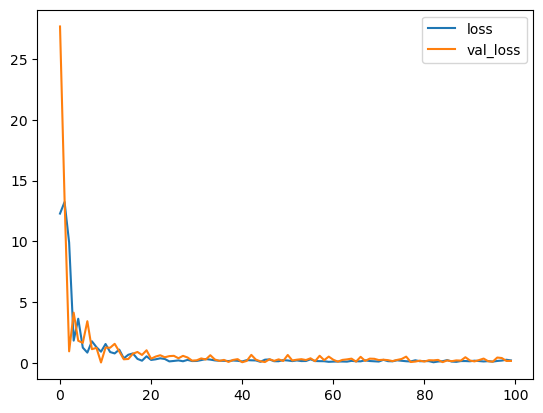

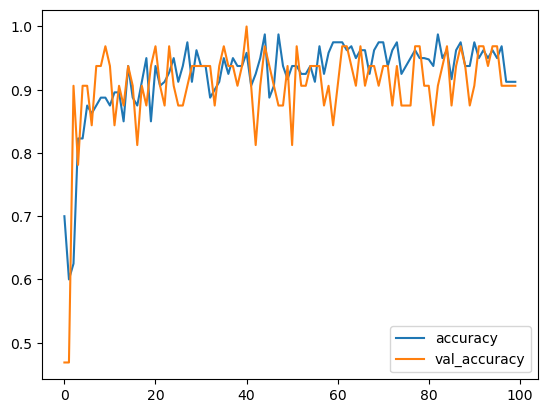

In [13]:
show_accuracy_and_loss(history)

### 7.2.FNN training with augmentation and model results
When using FNN to classify the Covid-19 images, while using augmentation the model showed lower accuracy(92.5%), and much higher variance in the validation dataset predictions which indicates overfitting, i.e the model is fitting
the noise in the data, which indicates that it will not genralize well.

The model Test accuracy accuracy(92.5%)



## 7.3.Subtask 1.2: Develop CNN models

In this subtask we will develop different CNN models using Keras, we will also employ different genralization techniques and guage how each technique affects the model performance, we will start with a simple CNN architecture, and explore how different genralization techniques affects the model performance and the model accuracy.

Based on the finidings in this section we will elect the generalization techniques and try the elected techniques with more complex CNN models


### 7.4.Start with a simple CNN architecture, and test the model with different genralization techniques
We will start with a minimal CNN using the reusable layers from the KerasLayers() class we created earlier.

Then we will elect a CNN model with the best perfromance and afterwards we will use the following techniques
to improve the model performance

- [✅] Data Augumentation 
- [✅] Early stopping
- [✅] Dropout
- [✅] Batch Normalization
- [✅] Weight Decay

### 7.5.Start with a simple CNN model
<ul>
  <li>Input layer: The first layer is an input shape layer with a convolutional 2D layer of size 32
</li>
  <li>Convolutional layer: a convolutional 2D layer with 64 filters, ReLU activation function, and bias and a 2X2 size pooling
</li>
  <li>Flatten layer: The output of the second max pooling layer is flattened into a 1D array/li>
  <li>Dense layer: A fully connected layer with 128 neurons and ReLU activation function.</li>
  <li>Output layer: The output layer is a dense layer with a single neuron and a sigmoid activation function. This layer produces a binary output indicating the predicted class (Covid-19 or Normal) of the input image.</li>

</ul>

In [14]:
# Experiment: Use a simple CNN

# variables
CNN_CLASSES=2

# initialization
data_set = DataSet()
cnn_layers = KerasLayers()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()

# add keras layers for CNN architecture
#layer 1
cnn_layers.add_input_shape_conv2D_layer(size=32, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), activation_fn='relu', use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#layer 2
cnn_layers.add_conv2D_layer(64,'relu',use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)
cnn_layers.flatten()

#layer 3
cnn_layers.add_dense_layer(128, 'relu')

#layer 4 (output)
cnn_layers.add_dense_layer(2, 'softmax')

# output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(cnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )      


Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 11.3550 - accuracy: 0.5208 - val_loss: 6.1517 - val_accuracy: 0.5312
Epoch 2/100
3/3 [==============================] - 3s 898ms/step - loss: 5.0800 - accuracy: 0.5125 - val_loss: 1.6823 - val_accuracy: 0.5312
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 1.1533 - accuracy: 0.4000 - val_loss: 0.8058 - val_accuracy: 0.5312
Epoch 4/100
3/3 [==============================] - 3s 875ms/step - loss: 0.7664 - accuracy: 0.4625 - val_loss: 0.8836 - val_accuracy: 0.4375
Epoch 5/100
3/3 [==============================] - 2s 867ms/step - loss: 0.5716 - accuracy: 0.7125 - val_loss: 0.4285 - val_accuracy: 0.9062
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 0.2989 - accuracy: 0.9896 - val_loss: 0.2346 - val_accuracy: 0.9688
Epoch 7/100
3/3 [========================

3/3 [==============================] - 3s 845ms/step - loss: 6.0408e-06 - accuracy: 1.0000 - val_loss: 0.2736 - val_accuracy: 0.9688
Epoch 58/100
3/3 [==============================] - 3s 1s/step - loss: 8.9821e-06 - accuracy: 1.0000 - val_loss: 0.2811 - val_accuracy: 0.9688
Epoch 59/100
3/3 [==============================] - 3s 949ms/step - loss: 9.6195e-06 - accuracy: 1.0000 - val_loss: 0.2820 - val_accuracy: 0.9688
Epoch 60/100
3/3 [==============================] - 3s 835ms/step - loss: 7.0078e-06 - accuracy: 1.0000 - val_loss: 0.8936 - val_accuracy: 0.9375
Epoch 61/100
3/3 [==============================] - 2s 735ms/step - loss: 8.8867e-06 - accuracy: 1.0000 - val_loss: 0.9017 - val_accuracy: 0.9375
Epoch 62/100
3/3 [==============================] - 3s 1s/step - loss: 8.2609e-06 - accuracy: 1.0000 - val_loss: 0.9080 - val_accuracy: 0.9375
Epoch 63/100
3/3 [==============================] - 3s 1s/step - loss: 6.0288e-06 - accuracy: 1.0000 - val_loss: 0.9111 - val_accuracy: 0.9375


2/2 [==============================] - 1s 48ms/step - loss: 0.0111 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 0.011102378368377686
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 2)                 23907650  
                                                                 
Total params: 23,907,650
Trainable params: 23,907,650
Non-trainable params: 0
_________________________________________________________________


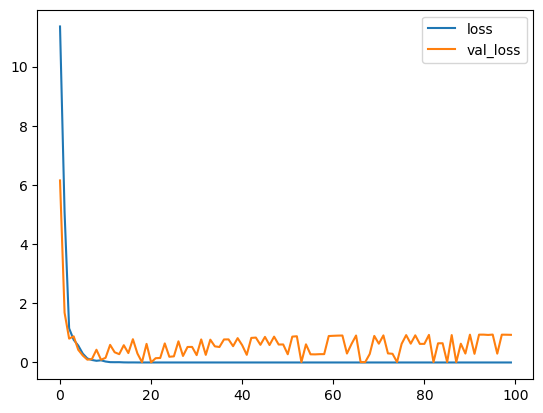

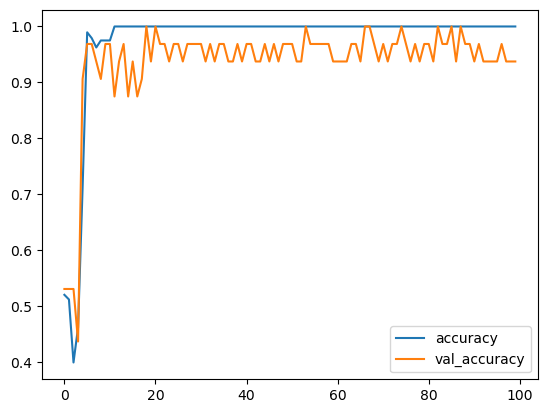

In [15]:
# show the model metrics of the simple CNN model
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)
show_accuracy_and_loss(history)

### 7.6.Simple CNN training and model results
When using the simple CNN  mode to classify the Covid-19 images, the model stopped improving after epoch number 10, the model acheived an excellent accuracy with consistent training and validation accuracies.

The test accuracy is 100%

We will attempt to train a more complex CNN model on the data and observe the differences

## 7.7.Test with a more complex CNN model

note: I added more layers to the model to allow extracting more features from the images
<ul>
  <li>Input layer: The first layer is an input shape layer with a convolutional 2D layer of size 32
</li>
  <li>A Convolutional block: containing 1 convolutional 2D layer with 64 filters, ReLU activation function, and bias and a 2X2 size pooling
</li>
  <li>A Convolutional block: containing 2 convolutional 2D layer with 128 filters, ReLU activation function, and bias and a 2X2 size pooling
</li>
  <li>A Convolutional block: containing 1 convolutional 2D layer with 128 filters, ReLU activation function, and bias and a 2X2 size pooling
</li>
  <li>Flatten layer: The output of the second max pooling layer is flattened into a 1D array/li>
  <li>Dense layer: A fully connected layer with 128 neurons and ReLU activation function.</li>
  <li>Output layer: The output layer is a dense layer with a single neuron and a sigmoid activation function. This layer produces a binary output indicating the predicted class (Covid-19 or Normal) of the input image.</li>

</ul>

In [16]:
# Use a more complex CNN model
# Experiment: Use a simple CNN

# variables
CNN_CLASSES=2

# initialization
data_set = DataSet()
cnn_layers = KerasLayers()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()

# add keras layers for CNN architecture
#block 1
cnn_layers.add_input_shape_conv2D_layer(size=32, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), activation_fn='relu', use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#block 2
cnn_layers.add_conv2D_layer(64,'relu',use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#block 3
cnn_layers.add_conv2D_layer(128,'relu',use_bias=True)
cnn_layers.add_conv2D_layer(128,'relu',use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#block 4
cnn_layers.add_conv2D_layer(256,'relu',use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)
cnn_layers.flatten()

#block 5
cnn_layers.add_dense_layer(512, 'relu')

#block 6
cnn_layers.add_dense_layer(2, 'softmax')


# output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(cnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )     


Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 5s 1s/step - loss: 1.0207 - accuracy: 0.4875 - val_loss: 0.6786 - val_accuracy: 0.5312
Epoch 2/100
3/3 [==============================] - 4s 1s/step - loss: 0.6914 - accuracy: 0.4375 - val_loss: 0.6678 - val_accuracy: 0.6250
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: 0.6522 - accuracy: 0.5125 - val_loss: 0.6017 - val_accuracy: 0.8438
Epoch 4/100
3/3 [==============================] - 4s 2s/step - loss: 0.5087 - accuracy: 0.8375 - val_loss: 0.6613 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 0.4560 - accuracy: 0.7875 - val_loss: 0.2495 - val_accuracy: 0.9688
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.2454 - accuracy: 0.9000 - val_loss: 0.1325 - val_accuracy: 0.9688
Epoch 7/100
3/3 [==============================] - 

3/3 [==============================] - 4s 1s/step - loss: 1.0520e-06 - accuracy: 1.0000 - val_loss: 2.0377 - val_accuracy: 0.7812
Epoch 59/100
3/3 [==============================] - 4s 1s/step - loss: 8.9555e-07 - accuracy: 1.0000 - val_loss: 2.9073 - val_accuracy: 0.7500
Epoch 60/100
3/3 [==============================] - 4s 1s/step - loss: 1.2331e-06 - accuracy: 1.0000 - val_loss: 2.7809 - val_accuracy: 0.7812
Epoch 61/100
3/3 [==============================] - 4s 1s/step - loss: 9.5516e-07 - accuracy: 1.0000 - val_loss: 3.0000 - val_accuracy: 0.7812
Epoch 62/100
3/3 [==============================] - 3s 1s/step - loss: 1.3009e-06 - accuracy: 1.0000 - val_loss: 1.4498 - val_accuracy: 0.8750
Epoch 63/100
3/3 [==============================] - 4s 1s/step - loss: 1.4841e-06 - accuracy: 1.0000 - val_loss: 1.5929 - val_accuracy: 0.8750
Epoch 64/100
3/3 [==============================] - 3s 1s/step - loss: 1.1504e-06 - accuracy: 1.0000 - val_loss: 2.8039 - val_accuracy: 0.8125
Epoch 65/100

2/2 [==============================] - 1s 63ms/step - loss: 1.7057 - accuracy: 0.9750
Test accuracy: 0.9750000238418579
Test loss: 1.7056623697280884
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 2)                 16397250  
                                                                 
Total params: 16,397,250
Trainable params: 16,397,250
Non-trainable params: 0
_________________________________________________________________


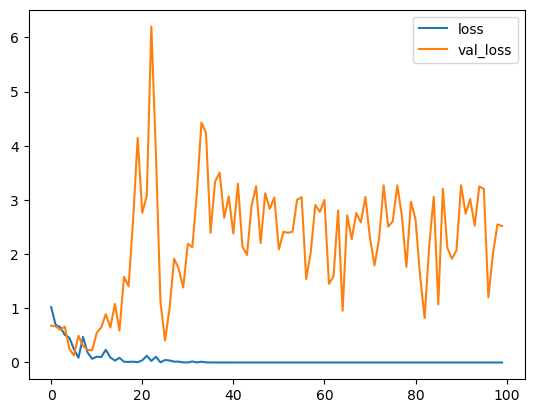

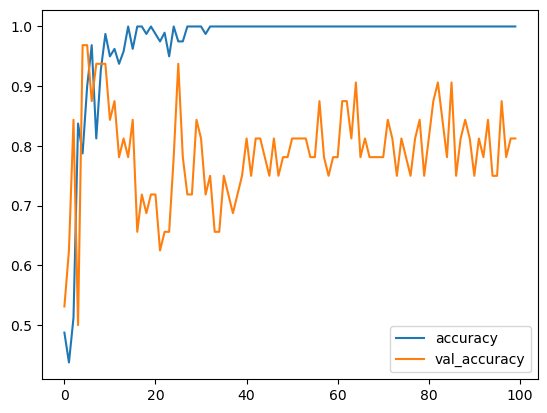

In [17]:
# show the model metrics of the complex CNN model
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)
show_accuracy_and_loss(history)

### 7.8.Complex CNN architecture training and model results 
using a more complex CNN model, the model performed worse than using a simple CNN architecture. The recorded test accuracy was 97.5%, and stopped improving after epoch 30 .


### Data Augumentation 
In the context of image processing, data augmentation involves applying various transformations to the original images, such as rotation, scaling, flipping, shearing, zooming, and changing brightness or contrast. By applying these transformations, we can generate new images that are similar to the original images but have slightly different features or characteristics.

Since our dataset is small (200 images in total), data augumentataion is a good technique to increase the amount of training data and to avoid overfitting the model to the 200 images, in theory this should make the model generalize well when encoutering images in the future that has minor shifts in orientation, brightness or contrast. We will explore how this technique improves our model.



### Use data augumentation with the complex CNN model
Here we use our DataSet class to add data augumentation, and test how the model performs

In [18]:
# use complex CNN model with data augmentation
# variables
CNN_CLASSES=2

# initialization
data_set = DataSet()
cnn_layers = KerasLayers()

# add data augumentation
data_set.add_rotation(5)
data_set.add_zoom(0.1)
data_set.add_shear(0.1)
data_set.add_width_shift(0.1)
data_set.add_height_shift(0.1)
data_set.add_horizontal_flip()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()

# add keras layers for CNN architecture
#block 1
cnn_layers.add_input_shape_conv2D_layer(size=32, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), activation_fn='relu', use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#block 2
cnn_layers.add_conv2D_layer(64,'relu',use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#block 3
cnn_layers.add_conv2D_layer(128,'relu',use_bias=True)
cnn_layers.add_conv2D_layer(128,'relu',use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#block 4
cnn_layers.add_conv2D_layer(256,'relu',use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)
cnn_layers.flatten()

#block 5
cnn_layers.add_dense_layer(512, 'relu')

#block 6
cnn_layers.add_dense_layer(2, 'softmax')


# output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(cnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )      


Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 6s 2s/step - loss: 1.5928 - accuracy: 0.4583 - val_loss: 0.7048 - val_accuracy: 0.4688
Epoch 2/100
3/3 [==============================] - 5s 1s/step - loss: 0.6954 - accuracy: 0.4896 - val_loss: 0.7016 - val_accuracy: 0.4688
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: 0.6857 - accuracy: 0.6250 - val_loss: 0.6763 - val_accuracy: 0.6562
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.6699 - accuracy: 0.6375 - val_loss: 0.6784 - val_accuracy: 0.4062
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 0.6550 - accuracy: 0.6146 - val_loss: 0.6455 - val_accuracy: 0.6875
Epoch 6/100
3/3 [==============================] - 5s 2s/step - loss: 0.6372 - accuracy: 0.6562 - val_loss: 0.5425 - val_accuracy: 0.9062
Epoch 7/100
3/3 [==============================] - 

3/3 [==============================] - 4s 2s/step - loss: 0.1344 - accuracy: 0.9625 - val_loss: 0.1877 - val_accuracy: 0.9688
Epoch 60/100
3/3 [==============================] - 4s 2s/step - loss: 0.1370 - accuracy: 0.9625 - val_loss: 0.3646 - val_accuracy: 0.8438
Epoch 61/100
3/3 [==============================] - 4s 2s/step - loss: 0.1311 - accuracy: 0.9750 - val_loss: 0.4531 - val_accuracy: 0.9062
Epoch 62/100
3/3 [==============================] - 4s 1s/step - loss: 0.1704 - accuracy: 0.9250 - val_loss: 0.4437 - val_accuracy: 0.8438
Epoch 63/100
3/3 [==============================] - 5s 2s/step - loss: 0.1364 - accuracy: 0.9375 - val_loss: 0.5122 - val_accuracy: 0.7812
Epoch 64/100
3/3 [==============================] - 5s 2s/step - loss: 0.2147 - accuracy: 0.9250 - val_loss: 0.4612 - val_accuracy: 0.8438
Epoch 65/100
3/3 [==============================] - 4s 2s/step - loss: 0.4367 - accuracy: 0.8625 - val_loss: 0.9195 - val_accuracy: 0.9062
Epoch 66/100
3/3 [======================

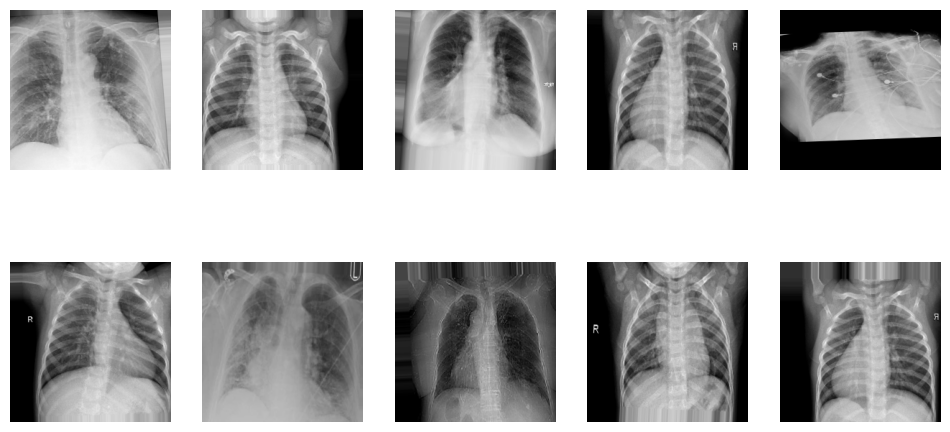

In [19]:
data_set.plot()

2/2 [==============================] - 1s 93ms/step - loss: 0.0417 - accuracy: 0.9750
Test accuracy: 0.9750000238418579
Test loss: 0.041710175573825836
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 2)                 16397250  
                                                                 
Total params: 16,397,250
Trainable params: 16,397,250
Non-trainable params: 0
_________________________________________________________________


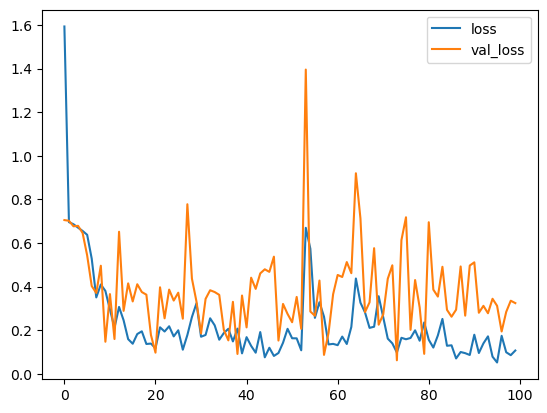

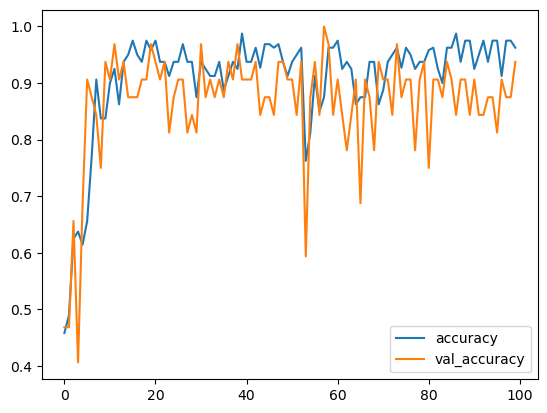

In [20]:
# show the model metrics of the complex CNN model with augumentation implemented
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)
show_accuracy_and_loss(history)

### 7.9.Results of adding data augumentation with the complex CNN model
when using data augmentation with the simple CNN, the accuracy recorded was 100%, the model stopped improving after epoch 25, this indicates augmentation makes complex CNNs performance better for our dataset.

### 7.10.Augument with the simple CNN
Here we use the simple CNN we created earlier to test how the augumentation affects the model

Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


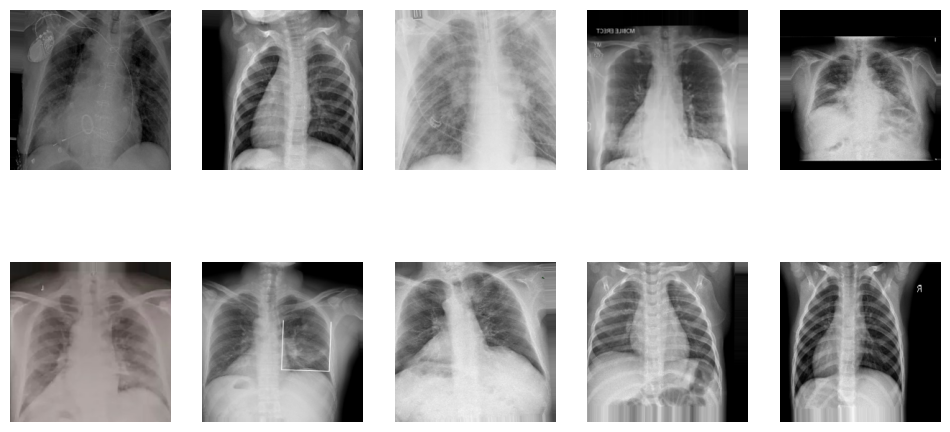

Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 8.5816 - accuracy: 0.4375 - val_loss: 2.4252 - val_accuracy: 0.4688
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.9233 - accuracy: 0.6500 - val_loss: 0.2034 - val_accuracy: 0.9688
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.4457 - accuracy: 0.8000 - val_loss: 0.4158 - val_accuracy: 0.8125
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.3462 - accuracy: 0.8750 - val_loss: 0.2582 - val_accuracy: 0.9062
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 0.2679 - accuracy: 0.9500 - val_loss: 0.2492 - val_accuracy: 0.8750
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.3028 - accuracy: 0.8854 - val_loss: 0.2825 - val_accuracy: 0.9062
Epoch 7/100
3/3 [==============================] - 3s 956ms/step - loss: 0.2640 - accuracy: 0.9250 - val_loss: 0.2734 - val_accuracy: 0.9062
Epoch 8/100
3/3 [==============

Epoch 60/100
3/3 [==============================] - 3s 1s/step - loss: 0.0319 - accuracy: 0.9875 - val_loss: 0.4419 - val_accuracy: 0.8750
Epoch 61/100
3/3 [==============================] - 3s 1s/step - loss: 0.0374 - accuracy: 0.9896 - val_loss: 0.0770 - val_accuracy: 0.9375
Epoch 62/100
3/3 [==============================] - 3s 1s/step - loss: 0.0775 - accuracy: 0.9750 - val_loss: 0.5242 - val_accuracy: 0.9062
Epoch 63/100
3/3 [==============================] - 3s 1s/step - loss: 0.0727 - accuracy: 0.9875 - val_loss: 0.3956 - val_accuracy: 0.9375
Epoch 64/100
3/3 [==============================] - 3s 1s/step - loss: 0.1167 - accuracy: 0.9500 - val_loss: 0.1011 - val_accuracy: 0.9688
Epoch 65/100
3/3 [==============================] - 3s 970ms/step - loss: 0.1615 - accuracy: 0.9625 - val_loss: 0.5279 - val_accuracy: 0.9062
Epoch 66/100
3/3 [==============================] - 3s 1s/step - loss: 0.0370 - accuracy: 0.9750 - val_loss: 0.3647 - val_accuracy: 0.9062
Epoch 67/100
3/3 [======

In [21]:
# use complex CNN model with data augmentation
# variables
CNN_CLASSES=2

# initialization
data_set = DataSet()
cnn_layers = KerasLayers()

# add data augumentation
data_set.add_rotation(5)
data_set.add_zoom(0.1)
data_set.add_shear(0.1)
data_set.add_width_shift(0.1)
data_set.add_height_shift(0.1)
data_set.add_horizontal_flip()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()

data_set.plot()

# add keras layers for CNN architecture
#layer 1
cnn_layers.add_input_shape_conv2D_layer(size=32, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), activation_fn='relu', use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#layer 2
cnn_layers.add_conv2D_layer(64,'relu',use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)
cnn_layers.flatten()

#layer 3
cnn_layers.add_dense_layer(128, 'relu')

#layer 4 (output)
cnn_layers.add_dense_layer(2, 'softmax')

# output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(cnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )      


2/2 [==============================] - 1s 77ms/step - loss: 0.0228 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 0.02277972176671028
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 2)                 23907650  
                                                                 
Total params: 23,907,650
Trainable params: 23,907,650
Non-trainable params: 0
_________________________________________________________________


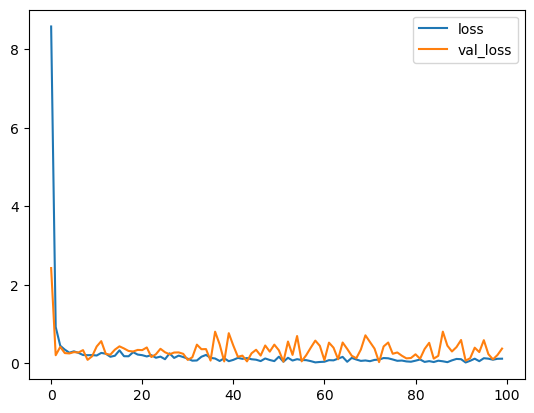

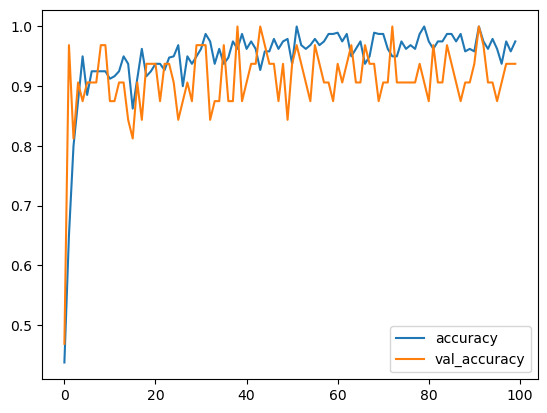

In [22]:
# show the model metrics of the complex CNN model with augumentation implemented
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)
show_accuracy_and_loss(history)

### 7.11.Results of adding data augumentation with the 
when using data augmentation with the simple CNN, the accuracy recorded was 97.5%, the model stopped improving after epoch 16.

### 7.12.Batch Normalization

Batch normalization is a technique that normalizes the activations of the previous layer before passing them to the next layer. This can help prevent overfitting by reducing the internal covariate shift and making the optimization process more stable

We will explore how this techinque improves our model


In [23]:
# Use a simple CNN model to do the batch normalization
# Experiment: Use a simple CNN

# variables
CNN_CLASSES=2

# initialization
data_set = DataSet()
cnn_layers = KerasLayers()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()

# add keras layers for CNN architecture
#layer 1
cnn_layers.add_input_shape_conv2D_layer(size=32, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), activation_fn='relu', use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#layer 2
cnn_layers.add_conv2D_layer(64,'relu',use_bias=True)
cnn_layers.add_batch_normalization()
cnn_layers.add_max_pooling_2D(2,2)
cnn_layers.flatten()

#layer 3
cnn_layers.add_dense_layer(128, 'relu')

#layer 4 (output)
cnn_layers.add_dense_layer(2, 'softmax')

# output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(cnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )       


Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 3s 1s/step - loss: 15.2462 - accuracy: 0.6625 - val_loss: 1.9753 - val_accuracy: 0.4375
Epoch 2/100
3/3 [==============================] - 2s 794ms/step - loss: 2.3393 - accuracy: 0.9125 - val_loss: 1.3789 - val_accuracy: 0.4375
Epoch 3/100
3/3 [==============================] - 2s 1s/step - loss: 0.9471 - accuracy: 0.9625 - val_loss: 0.1430 - val_accuracy: 0.9375
Epoch 4/100
3/3 [==============================] - 2s 788ms/step - loss: 1.9787e-06 - accuracy: 1.0000 - val_loss: 1.4417 - val_accuracy: 0.7500
Epoch 5/100
3/3 [==============================] - 3s 912ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 5.8647 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 2s 980ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 10.5667 - val_accuracy: 0.5000
Epoch 7/100
3/3 [================

Epoch 57/100
3/3 [==============================] - 3s 832ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 2.2065 - val_accuracy: 0.7812
Epoch 58/100
3/3 [==============================] - 2s 779ms/step - loss: 3.4273e-08 - accuracy: 1.0000 - val_loss: 2.6397 - val_accuracy: 0.7500
Epoch 59/100
3/3 [==============================] - 3s 1s/step - loss: 5.0275e-04 - accuracy: 1.0000 - val_loss: 3.8729 - val_accuracy: 0.7500
Epoch 60/100
3/3 [==============================] - 2s 651ms/step - loss: 2.5121e-04 - accuracy: 1.0000 - val_loss: 2.3844 - val_accuracy: 0.8125
Epoch 61/100
3/3 [==============================] - 3s 959ms/step - loss: 2.5926e-06 - accuracy: 1.0000 - val_loss: 1.5604 - val_accuracy: 0.9062
Epoch 62/100
3/3 [==============================] - 3s 915ms/step - loss: 3.2536e-05 - accuracy: 1.0000 - val_loss: 2.7537 - val_accuracy: 0.8438
Epoch 63/100
3/3 [==============================] - 3s 921ms/step - loss: 4.8338e-04 - accuracy: 1.0000 - val_loss: 3.4169 - val_ac

2/2 [==============================] - 1s 60ms/step - loss: 0.7716 - accuracy: 0.9500
Test accuracy: 0.949999988079071
Test loss: 0.7715729475021362
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 2)                 23907906  
                                                                 
Total params: 23,907,906
Trainable params: 23,907,778
Non-trainable params: 128
_________________________________________________________________


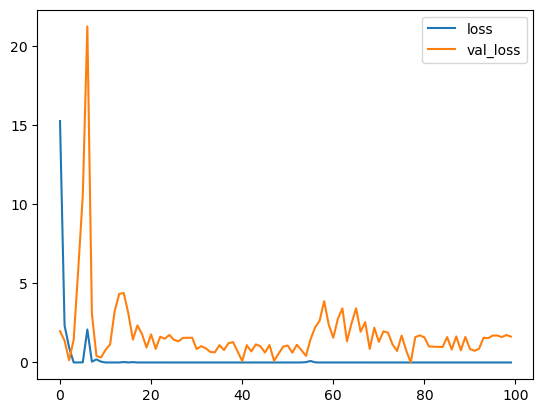

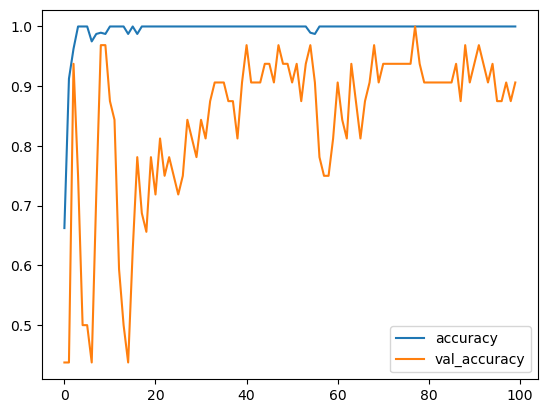

In [24]:
# show the model metrics of the complex CNN model with batch normalization implemented
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)
show_accuracy_and_loss(history)

### 7.13.Results of adding batch normalization 
When using the batch normalization the model suffered from loss in accuracy averaging 0.8%, it was only until the 75th epoch at which accuracy started improving, the model suffered from very high variance in the validation dataset, which inidcates that the model lacked consistency when doing predictions.

This concludes that we can discard batch normalization for this dataset

### 7.14.Weight Decay 

Since our dataset is small (200 images in total), and to avoid overfitting the data we need to
penalize the learning of large weights.

In this experiment we will use l2 regularization

In [25]:
# Use a simple CNN model
# Experiment: Use a simple CNN

# variables
CNN_CLASSES=2
L2_VALUE=0.2

# initialization
data_set = DataSet()
cnn_layers = KerasLayers()

# add data augumentation
data_set.add_rotation(5)
data_set.add_zoom(0.1)
data_set.add_shear(0.1)
data_set.add_width_shift(0.1)
data_set.add_height_shift(0.1)
data_set.add_horizontal_flip()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()



# add keras layers for CNN architecture
#layer 1
cnn_layers.add_input_shape_conv2D_layer(size=32, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), activation_fn='relu', use_bias=True)
cnn_layers.add_max_pooling_2D(2,2)

#layer 2
cnn_layers.add_l2_regularized_conv2D_layer(64,'relu',use_bias=True,l_value=L2_VALUE)
cnn_layers.add_max_pooling_2D(2,2)
cnn_layers.flatten()

#layer 3
cnn_layers.add_dense_layer(128, 'relu')

#layer 4 (output)
cnn_layers.add_dense_layer(2, 'softmax')


model = tf.keras.models.Sequential([
     tf.keras.Sequential(cnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )    

Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 12.3839 - accuracy: 0.5312 - val_loss: 13.1590 - val_accuracy: 0.4688
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 10.5026 - accuracy: 0.4583 - val_loss: 8.5900 - val_accuracy: 0.5312
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 7.7587 - accuracy: 0.6250 - val_loss: 7.0894 - val_accuracy: 0.8438
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 6.8609 - accuracy: 0.8375 - val_loss: 6.5750 - val_accuracy: 0.8750
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 6.3928 - accuracy: 0.8000 - val_loss: 5.9399 - val_accuracy: 0.8750
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 5.8015 - accuracy: 0.8958 - val_loss: 5.4819 - val_accuracy: 0.9688
Epoch 7/100
3/3 [==============================]

Epoch 59/100
3/3 [==============================] - 3s 1s/step - loss: 0.7262 - accuracy: 0.9625 - val_loss: 0.7231 - val_accuracy: 0.9375
Epoch 60/100
3/3 [==============================] - 3s 1s/step - loss: 0.7045 - accuracy: 0.9625 - val_loss: 1.1379 - val_accuracy: 0.8438
Epoch 61/100
3/3 [==============================] - 3s 1s/step - loss: 0.7204 - accuracy: 0.9625 - val_loss: 0.7941 - val_accuracy: 0.9688
Epoch 62/100
3/3 [==============================] - 3s 1s/step - loss: 0.7243 - accuracy: 0.9625 - val_loss: 0.7392 - val_accuracy: 0.9688
Epoch 63/100
3/3 [==============================] - 3s 968ms/step - loss: 0.6211 - accuracy: 0.9750 - val_loss: 0.8555 - val_accuracy: 0.9062
Epoch 64/100
3/3 [==============================] - 3s 1s/step - loss: 0.6495 - accuracy: 0.9750 - val_loss: 0.7518 - val_accuracy: 0.9375
Epoch 65/100
3/3 [==============================] - 3s 1s/step - loss: 0.6447 - accuracy: 0.9792 - val_loss: 0.8307 - val_accuracy: 0.9375
Epoch 66/100
3/3 [======

2/2 [==============================] - 1s 57ms/step - loss: 0.2886 - accuracy: 0.9750
Test accuracy: 0.9750000238418579
Test loss: 0.288624107837677
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 2)                 23907650  
                                                                 
Total params: 23,907,650
Trainable params: 23,907,650
Non-trainable params: 0
_________________________________________________________________


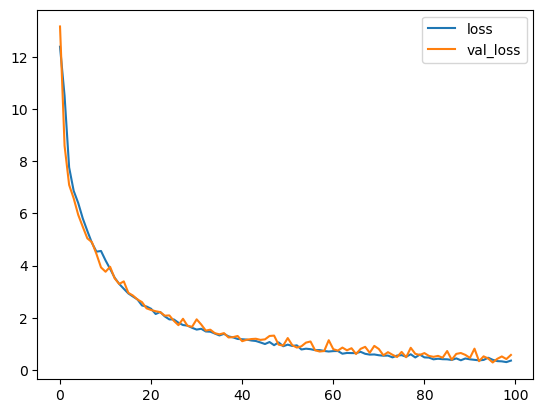

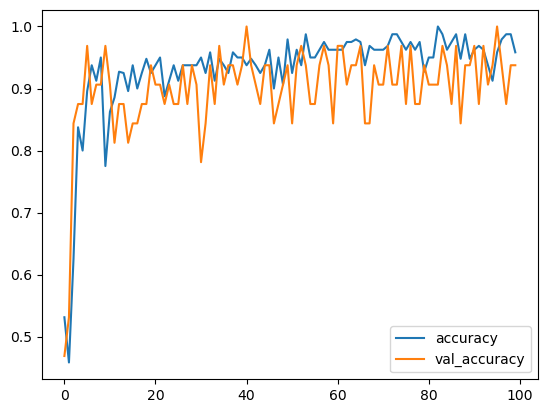

In [26]:
# show the model metrics of the complex CNN model with batch dropout implemented
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)
show_accuracy_and_loss(history)


### 7.15.Results of adding weight decay 
When using the weight decay approach, the accuracy recorded was 97.5%. The model was consistent throughout the training process, but struggled with the validation set since there was a large gap between training and validation curves, would be a good approach to implement early stopping


### 7.16.Dropout 
We explore adding drop out to improve the model generalization

In [27]:
# Experiment: Use Simple CNN architecture
# Add dropout

# variables
CNN_CLASSES=2
L2_VALUE=0.2
DROPOUT_PROBABILITY=0.25

# initialization
data_set = DataSet()
cnn_layers = KerasLayers()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()

# add keras layers for CNN architecture
#layer 1
cnn_layers.add_input_shape_conv2D_layer(size=32, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), activation_fn='relu', use_bias=True)
cnn_layers.add_dropout(probability=DROPOUT_PROBABILITY)
cnn_layers.add_max_pooling_2D(2,2)

#layer 2
cnn_layers.add_l2_regularized_conv2D_layer(64,'relu',use_bias=True,l_value=L2_VALUE)
cnn_layers.add_dropout(probability=DROPOUT_PROBABILITY)
cnn_layers.add_max_pooling_2D(2,2)
cnn_layers.flatten()

#layer 3
cnn_layers.add_dense_layer(128, 'relu')

#layer 4 (output)
cnn_layers.add_dense_layer(2, 'softmax')



# output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(cnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )    

Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 18.6220 - accuracy: 0.5938 - val_loss: 12.2589 - val_accuracy: 0.5312
Epoch 2/100
3/3 [==============================] - 3s 891ms/step - loss: 12.1553 - accuracy: 0.5938 - val_loss: 8.1150 - val_accuracy: 0.5625
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 8.1206 - accuracy: 0.5875 - val_loss: 7.0425 - val_accuracy: 0.9062
Epoch 4/100
3/3 [==============================] - 3s 775ms/step - loss: 6.7478 - accuracy: 0.8875 - val_loss: 6.5115 - val_accuracy: 0.9375
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 6.1821 - accuracy: 0.9500 - val_loss: 5.9769 - val_accuracy: 0.9375
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 5.6650 - accuracy: 0.9500 - val_loss: 5.4852 - val_accuracy: 0.9375
Epoch 7/100
3/3 [=========================

3/3 [==============================] - 2s 1s/step - loss: 0.9666 - accuracy: 1.0000 - val_loss: 1.1277 - val_accuracy: 0.9688
Epoch 59/100
3/3 [==============================] - 3s 993ms/step - loss: 0.9490 - accuracy: 1.0000 - val_loss: 1.2173 - val_accuracy: 0.9375
Epoch 60/100
3/3 [==============================] - 3s 878ms/step - loss: 0.9301 - accuracy: 1.0000 - val_loss: 0.9435 - val_accuracy: 1.0000
Epoch 61/100
3/3 [==============================] - 3s 1s/step - loss: 0.9132 - accuracy: 1.0000 - val_loss: 1.0815 - val_accuracy: 0.9688
Epoch 62/100
3/3 [==============================] - 3s 914ms/step - loss: 0.8959 - accuracy: 1.0000 - val_loss: 1.1573 - val_accuracy: 0.9375
Epoch 63/100
3/3 [==============================] - 2s 999ms/step - loss: 0.8787 - accuracy: 1.0000 - val_loss: 1.1484 - val_accuracy: 0.9375
Epoch 64/100
3/3 [==============================] - 3s 892ms/step - loss: 0.8616 - accuracy: 1.0000 - val_loss: 1.1733 - val_accuracy: 0.9375
Epoch 65/100
3/3 [=======

2/2 [==============================] - 1s 129ms/step - loss: 0.4596 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 0.4595769941806793
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 2)                 23907650  
                                                                 
Total params: 23,907,650
Trainable params: 23,907,650
Non-trainable params: 0
_________________________________________________________________


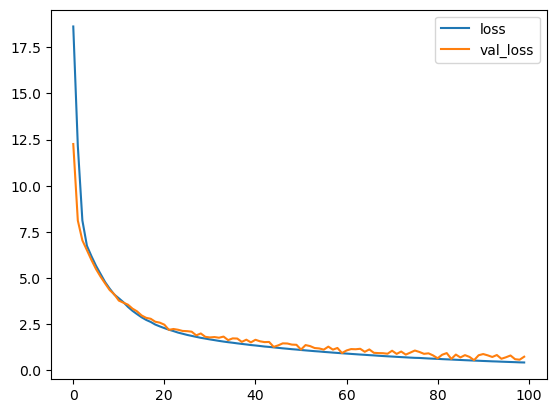

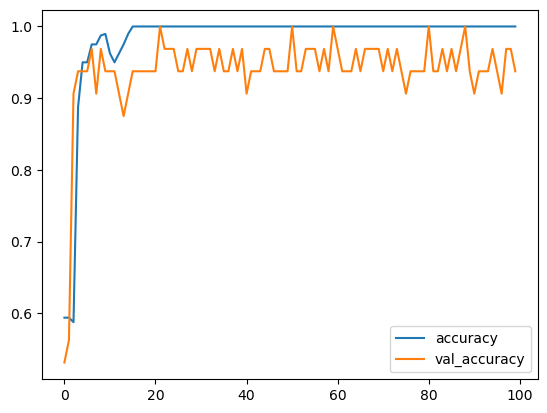

In [28]:

# show the model metrics of the complex CNN model with with l2 regularization and dropout, use average pooling
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)
show_accuracy_and_loss(history)

### 7.17.Results of using dropouts
When using dropout, the model reached a high degree of accuracy relatively quickly (100%). And stopped improving after epoch 22.

### 7.18.Using Average Pooling 
We will explore using average pooling, the main advantage of using average pooling over other pooling operations, such as max pooling, is that it is less likely to cause overfitting because it has fewer parameters to learn. Additionally, average pooling can help to smooth out the feature map and reduce the impact of small variations in the input.

In [29]:
# Experiment: Use convolutional neural net with l2 regularization and dropout, use average pooling, does it improve accuracy or decrease training time?

# variables
CNN_CLASSES=2
L2_VALUE=0.2
DROPOUT_PROBABILITY=0.25

# initialization
data_set = DataSet()
cnn_layers = KerasLayers()

# load and split data into training and validation
data_set.create_image_generator()
training_data_generator = data_set.create_train_generator()
validation_data_generator = data_set.create_validation_generator()
test_data_generator = data_set.create_test_generator()

# add keras layers for CNN architecture
#layer 1
cnn_layers.add_input_shape_conv2D_layer(32,(IMAGE_WIDTH,IMAGE_HEIGHT,3),'relu',use_bias=True)
cnn_layers.add_average_pooling_2D(2,2)

#layer 2
cnn_layers.add_l2_regularized_conv2D_layer(64,'relu',use_bias=True, l_value=L2_VALUE)
cnn_layers.add_dropout(probability=DROPOUT_PROBABILITY)
cnn_layers.add_average_pooling_2D(2,2)

#layer 3
cnn_layers.add_l2_regularized_conv2D_layer(128,'relu',use_bias=True, l_value=L2_VALUE)
cnn_layers.add_dropout(probability=DROPOUT_PROBABILITY)
cnn_layers.add_average_pooling_2D(2,2)

#layer 3
cnn_layers.add_l2_regularized_conv2D_layer(256,'relu',use_bias=True, l_value=L2_VALUE)
cnn_layers.add_dropout(probability=DROPOUT_PROBABILITY)
cnn_layers.add_average_pooling_2D(2,2)
cnn_layers.flatten()

#layer 5
cnn_layers.add_dense_layer(512, 'relu')

#layer 6
cnn_layers.add_dense_layer(2, 'softmax')


# output the model
model = tf.keras.models.Sequential([
     tf.keras.Sequential(cnn_layers.layers)
    ])

# train the model
history = train(
                model=model, 
                loss='categorical_crossentropy', 
                learning_rate=0.001, 
                epochs=EPOCHS, 
                train_generator=training_data_generator, 
                validation_generator=validation_data_generator
                )      


Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 57.7568 - accuracy: 0.5000 - val_loss: 51.2190 - val_accuracy: 0.5625
Epoch 2/100
3/3 [==============================] - 4s 1s/step - loss: 48.5497 - accuracy: 0.5417 - val_loss: 43.3987 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 41.0122 - accuracy: 0.4896 - val_loss: 36.4199 - val_accuracy: 0.9375
Epoch 4/100
3/3 [==============================] - 3s 994ms/step - loss: 34.3313 - accuracy: 0.7188 - val_loss: 30.3263 - val_accuracy: 0.9062
Epoch 5/100
3/3 [==============================] - 3s 985ms/step - loss: 28.5426 - accuracy: 0.7708 - val_loss: 25.0631 - val_accuracy: 0.9688
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 23.5602 - accuracy: 0.9000 - val_loss: 20.6132 - val_accuracy: 0.7812
Epoch 7/100
3/3 [================

3/3 [==============================] - 3s 971ms/step - loss: 0.1393 - accuracy: 1.0000 - val_loss: 0.6529 - val_accuracy: 0.9062
Epoch 59/100
3/3 [==============================] - 3s 1s/step - loss: 0.1555 - accuracy: 0.9875 - val_loss: 0.5708 - val_accuracy: 0.9062
Epoch 60/100
3/3 [==============================] - 3s 997ms/step - loss: 0.1498 - accuracy: 0.9875 - val_loss: 0.4042 - val_accuracy: 0.9375
Epoch 61/100
3/3 [==============================] - 3s 970ms/step - loss: 0.1253 - accuracy: 1.0000 - val_loss: 0.4005 - val_accuracy: 0.9375
Epoch 62/100
3/3 [==============================] - 3s 1s/step - loss: 0.1497 - accuracy: 0.9896 - val_loss: 0.2897 - val_accuracy: 0.9375
Epoch 63/100
3/3 [==============================] - 3s 1s/step - loss: 0.1310 - accuracy: 0.9896 - val_loss: 0.1508 - val_accuracy: 0.9688
Epoch 64/100
3/3 [==============================] - 3s 1s/step - loss: 0.1056 - accuracy: 1.0000 - val_loss: 0.1654 - val_accuracy: 0.9688
Epoch 65/100
3/3 [=============

2/2 [==============================] - 1s 58ms/step - loss: 0.1143 - accuracy: 0.9500
Test accuracy: 0.949999988079071
Test loss: 0.11430839449167252
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 2)                 19264322  
                                                                 
Total params: 19,264,322
Trainable params: 19,264,322
Non-trainable params: 0
_________________________________________________________________


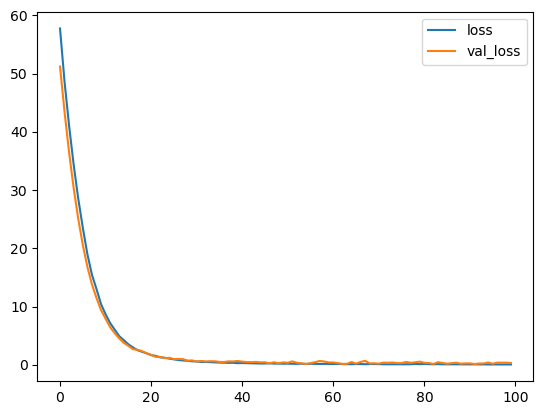

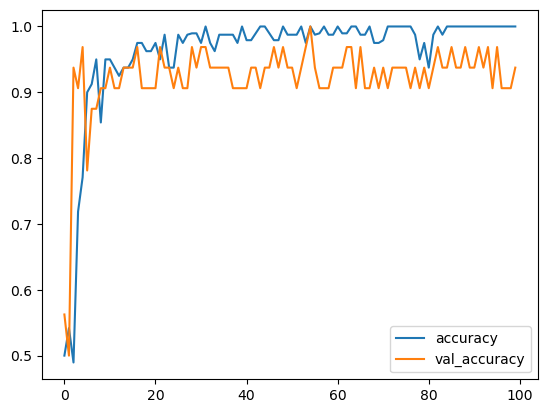

In [30]:

# show the model metrics of the complex CNN model with with l2 regularization and dropout, use average pooling
# this method prints the model summary, validation loss and accuracy for the FNN approach
show_model_metrics(model, test_data_generator)
show_accuracy_and_loss(history)

### 7.19.Results of adding average pooling
when using average pooling, the accuracy recorded was 95%. 
And the model also seemed to struggle with the validation data.

# 8.Resnet 50

Sub Task 2: Resnet 50 

Transfer learning is a machine learning method that solves problems in different but similar fields with existing knowledge [21]. Based on the transfer learning theory, this paper first carries on the model pre-training in the large-scale data sets of related fields (such as kaggle data sets), and extracts the weights and image features of the pre-training model for the initialization during the training process of the new small sample data set model, then uses the random Stochastic Gradient Descent (SGD) algorithm to fine-tune the model.

In this Sub Task we utilize the transfer learning approach to reduce the training time, and improve the model accuracy.

We will compare how transfer learning compares to the previous models we developed.

X. Han and R. Jin, "A Small Sample Image Recognition Method Based on ResNet and Transfer Learning," 2020 5th International Conference on Computational Intelligence and Applications (ICCIA), Beijing, China, 2020, pp. 76-81, doi: 10.1109/ICCIA49625.2020.00022.

#### This shows how benefecial it was to build a resuable KerasLayers class
It  will help us to build more complex models over resnet and test 
each model performance, without having to write complicated code, we will only write the code for freezing
the Resnet50 model layers, and removing the connected layer, other wise we use the same logic from the previous models.

## 8.1.Resnet50 Training Function
Abstract the Resnet50 training logic such that we can test with and without early stopping and data augmentation

In this function we build one level over our resuable logic of  DataSet(), KerasLayers() classes, by having a customizable function to train Resnet50 with different settings and observe how different techniques yeild different
results

In [31]:
def train_resnet50(early_stop_callback=None, use_augmentation=False):

    # initialization of reusable class logic
    data_set = DataSet()
    cnn_layers = KerasLayers()

    # Load the ResNet-50 model with pre-trained ImageNet weights
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))

    # Freeze all the layers in the pre-trained model
    for layer in resnet_model.layers:
        layer.trainable = False


    # load and split data into training and validation
    data_set.create_image_generator()
    training_data_generator = data_set.create_train_generator()
    validation_data_generator = data_set.create_validation_generator()
    test_data_generator = data_set.create_test_generator()

    if use_augmentation == True:
        # add data augumentation
        data_set.add_rotation(5)
        data_set.add_zoom(0.1)
        data_set.add_shear(0.1)
        data_set.add_width_shift(0.1)

    # add two trainable layers, to train the model on CXR images
    cnn_layers.flatten()
    cnn_layers.add_dense_layer(256, 'relu')
    cnn_layers.add_dense_layer(2, 'softmax')

    cnn_model = Sequential(cnn_layers.layers)

    # Define the Sequential object and add layers to it
    combined_model = Sequential([
        resnet_model,
        cnn_model
    ])



    # train the model
    history = train(
                    model=combined_model, 
                    loss='binary_crossentropy', 
                    learning_rate=0.001, 
                    epochs=EPOCHS, 
                    train_generator=training_data_generator, 
                    validation_generator=validation_data_generator,
                    callbacks=early_stop_callback)   
    
    return history, model, validation_data_generator

# 8.2.Train a Resnet50 Model without using data augmentation

In [32]:

history, model, validation_data_generator = train_resnet50(use_augmentation=True)



Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 6s 2s/step - loss: 9.1618 - accuracy: 0.3875 - val_loss: 4.9520 - val_accuracy: 0.4688
Epoch 2/100
3/3 [==============================] - 5s 2s/step - loss: 3.1189 - accuracy: 0.6562 - val_loss: 3.0047 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 2.6092 - accuracy: 0.5250 - val_loss: 1.9963 - val_accuracy: 0.4688
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 1.1851 - accuracy: 0.5375 - val_loss: 1.3222 - val_accuracy: 0.5312
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: 1.2280 - accuracy: 0.5104 - val_loss: 1.0761 - val_accuracy: 0.9375
Epoch 6/100
3/3 [==============================] - 5s 2s/step - loss: 0.6860 - accuracy: 0.8646 - val_loss: 0.9432 - val_accuracy: 0.7188
Epoch 7/100
3/3 [==============================] - 

3/3 [==============================] - 4s 2s/step - loss: 0.0672 - accuracy: 0.9750 - val_loss: 0.1825 - val_accuracy: 0.9375
Epoch 60/100
3/3 [==============================] - 4s 2s/step - loss: 0.0651 - accuracy: 0.9875 - val_loss: 0.1718 - val_accuracy: 0.9688
Epoch 61/100
3/3 [==============================] - 5s 2s/step - loss: 0.0656 - accuracy: 0.9896 - val_loss: 0.1122 - val_accuracy: 0.9688
Epoch 62/100
3/3 [==============================] - 4s 2s/step - loss: 0.0528 - accuracy: 0.9875 - val_loss: 0.2315 - val_accuracy: 0.9062
Epoch 63/100
3/3 [==============================] - 5s 2s/step - loss: 0.0682 - accuracy: 0.9875 - val_loss: 0.2376 - val_accuracy: 0.9062
Epoch 64/100
3/3 [==============================] - 7s 2s/step - loss: 0.0587 - accuracy: 0.9896 - val_loss: 0.2246 - val_accuracy: 0.9375
Epoch 65/100
3/3 [==============================] - 5s 2s/step - loss: 0.0551 - accuracy: 1.0000 - val_loss: 0.1634 - val_accuracy: 0.9375
Epoch 66/100
3/3 [======================

In [33]:
show_model_metrics(model, test_data_generator)


2/2 [==============================] - 1s 56ms/step - loss: 0.1143 - accuracy: 0.9500
Test accuracy: 0.949999988079071
Test loss: 0.11430839449167252
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 2)                 19264322  
                                                                 
Total params: 19,264,322
Trainable params: 19,264,322
Non-trainable params: 0
_________________________________________________________________


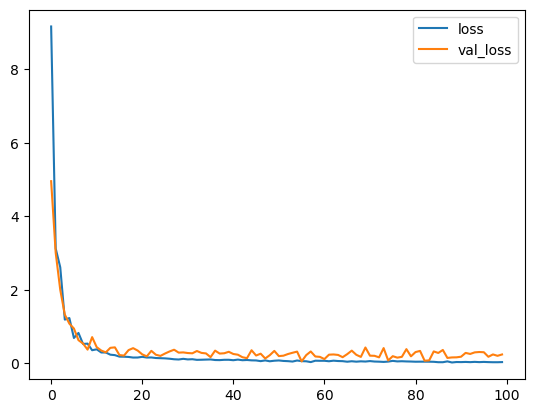

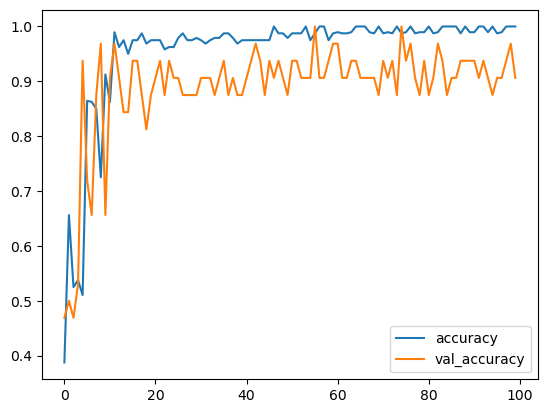

In [34]:
show_accuracy_and_loss(history)

## 8.3.Resnet50 using data augmentation training results
When using a Resnet50 pretrained model with data augmentation, the model shows a steady upwards training curve. The model reached a test accuracy of 95% and was one of the fastest model to converge (after epoch 17)


We will test early stopping and check if the model maintains the same accuracy of 95%


# 8.4.Train a resnet50 Model while using early stopping, use data augmentation

In [35]:
# start training
history, model, validation_data_generator = train_resnet50(use_augmentation=True,early_stop_callback=CALLBACKS)

Found 112 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
3/3 [==============================] - 7s 2s/step - loss: 11.0176 - accuracy: 0.4896 - val_loss: 4.4347 - val_accuracy: 0.5000
Epoch 2/100
3/3 [==============================] - 5s 2s/step - loss: 2.0175 - accuracy: 0.4750 - val_loss: 1.0301 - val_accuracy: 0.9375
Epoch 3/100
3/3 [==============================] - 4s 2s/step - loss: 0.9990 - accuracy: 0.8250 - val_loss: 0.8610 - val_accuracy: 0.8750
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.5661 - accuracy: 0.9625 - val_loss: 0.3608 - val_accuracy: 0.9375
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: 0.4943 - accuracy: 0.8375 - val_loss: 0.4901 - val_accuracy: 0.7188
Epoch 6/100
3/3 [==============================] - 4s 2s/step - loss: 0.3042 - accuracy: 0.9125 - val_loss: 0.1774 - val_accuracy: 1.0000
Epoch 7/100
3/3 [==============================] -

In [36]:
show_model_metrics(model, test_data_generator)


2/2 [==============================] - 1s 74ms/step - loss: 0.1143 - accuracy: 0.9500
Test accuracy: 0.949999988079071
Test loss: 0.11430840194225311
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 2)                 19264322  
                                                                 
Total params: 19,264,322
Trainable params: 19,264,322
Non-trainable params: 0
_________________________________________________________________


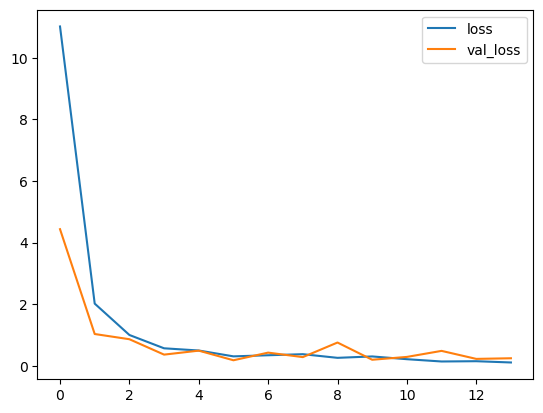

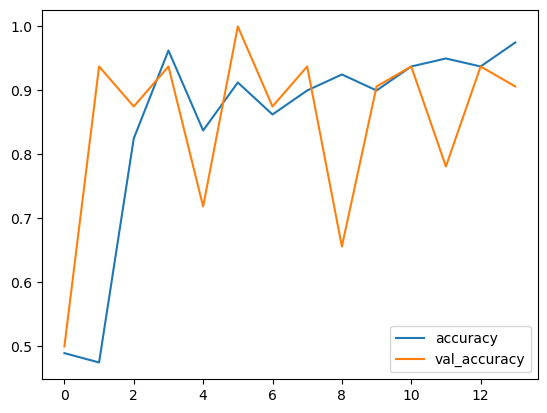

In [37]:
show_accuracy_and_loss(history)

## 8.5.Resnet50 using data augmentation and early stopping
The model shows a steady upwards training curve, unlike the models from Subtask 1, the variations among validation accuracy are much less than models experiments from Subtask 1 as well

lastly, when using a pre-trained Resnet50 with data augmentation and early stopping, the model shows a steady upwards training curve. The accuracy achieved was 95%.


In [39]:
def get_covid_result_from_output(output):
    if output <= COVID19_CERTAIN_NEGATIVE_THRESHOLD:
        return "Covid-19 Negative"
    elif output >= COVID19_CERTAIN_POSITIVE_THRESHOLD:
        return "Covid-19 Positive"
    else:
        return "Covid-19 Borderline"
    
# predict new image
def predict(image_path):
    test_image = image.load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    prediction = model.predict(test_image)
    return get_covid_result_from_output(prediction)


# 8.6.General notes

The data set is relatively small making it harder to guage the models

however in general 
whiel the Resnet50 perfomed much better and didn't fit the data too well as the CNN approach did

Predicting an image label
I remove two images one from the covid-19 folder and another from the Normal folder, both can be tested to predict the mdeo
on data that wasn't used in the trainig set
